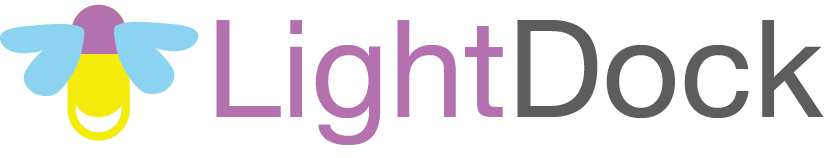

# LightDock: Protein-peptide docking using residue restraints

This tutorial covers the use of LightDock docking framework for modeling protein-peptide interactions using residue restraints. For more information about the protocol, please see the [LightDock tutorial page](https://lightdock.org/tutorials/0.9.3/restraints).

## 1. Install required software

LightDock is distributed as a Python package through the Python Package Index ([PyPI](https://pypi.org/project/lightdock/)) repository. We will install the last version of LightDock at the moment (0.9.4) and all its dependencies using the `pip` command.

**Note:** In case Google Colab complains about `numpy` version, just click on `Restart environment` and then run again the cell.

In [ ]:
!pip install lightdock==0.9.4

We will check if LightDock has been installed successfully by checking if the version is correct (it should appear `0.9.4`):


In [ ]:
!lightdock3.py --version

We will install [py3dmol](https://github.com/avirshup/py3dmol), a nice library for representing molecules in notebooks:

In [ ]:
!pip install py3dmol==2.0.3

## 2. Getting input data

We will obtain the input receptor (`1czy_receptor.pdb`) and ligand (`1czy_ligand.pdb`) PDB structures to run this tutorial, and a file in plain text containing the restraints (`restraints.list`):

In [ ]:
!wget https://lightdock.org/workshops/talca24/restraints_docking/data/1czy_receptor.pdb
!wget https://lightdock.org/workshops/talca24/restraints_docking/data/1czy_ligand.pdb
!wget https://lightdock.org/workshops/talca24/restraints_docking/data/restraints.list

Let's quicky visualize the input PDB structures:

In [ ]:
import py3Dmol

with open("1czy_receptor.pdb") as ifile:
    receptor = "".join([x for x in ifile])

view = py3Dmol.view(width=600, height=600)
view.addModelsAsFrames(receptor)
view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view.zoomTo()
view.show()

In [ ]:
import py3Dmol

with open("1czy_ligand.pdb") as ifile:
    ligand = "".join([x for x in ifile])

view = py3Dmol.view(width=600, height=600)
view.addModelsAsFrames(ligand)
view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view.zoomTo()
view.show()

## 3. Preparing the simulation

The fist step in any LightDock simulation is **setup**. We will make use of `lightdock3_setup.py` command to initialize our protein-peptide docking simulation using residue restraints.

We have selected two residues as restraints on the receptor partner: `A.411` and `A.466`. If you open `restraints.list` file for inspection, you will observe the format that LightDock is expecting for restraints (find more information on the [LightDock Theory](https://lightdock.org/workshops/talca24/lightdock_theory#22-residue-restraints) section):

```
R A.PHE.411
R A.ALA.466
```

Use the `lightdock3_setup.py` command to set up this LightDock simulation:

In [ ]:
!lightdock3_setup.py 1czy_receptor.pdb 1czy_ligand.pdb -anm -ar 10 -al 5 -rst restraints.list -spr 2 -noxt -now -noh

For this specific simulation, we have activated backbone flexibility with the ANM flag (`-anm`) and set the first 10 non-trivial modes for the receptor (`-ar 10`) and the first 5 non-trivial modes for the ligand (`-al 5`). The first 10 non-trivial is the default value for proteins, but for small peptides reducing it is recommended.

The flag `-spr 2` has been set for this tutorial, which indicates to keep only 2 swarms per restraint. By default this value is 20.

## 4. Running the simulation

By default, LightDock detects the number of CPU cores of your environment and uses all of them for speeding up the simulation. You can always set that value to a different one using the `-c` flag.

For the simulation to be run, only the `setup.json` file generated during the setup step and the number of steps (`100`) is required.

Simulating this system in Google Colab with 2 CPU cores takes around 2 minutes:

In [ ]:
!lightdock3.py setup.json 100

## 5. Generating poses and calculating clusters

In order to remove redundant predicted poses per swarm, we will generate all the predictions for every swarm and perform a clustering of the poses:

In [ ]:
!lgd_generate_conformations.py 1czy_receptor.pdb 1czy_ligand.pdb swarm_0/gso_100.out 200 --setup setup.json
!lgd_generate_conformations.py 1czy_receptor.pdb 1czy_ligand.pdb swarm_1/gso_100.out 200 --setup setup.json
!lgd_generate_conformations.py 1czy_receptor.pdb 1czy_ligand.pdb swarm_2/gso_100.out 200 --setup setup.json
!lgd_generate_conformations.py 1czy_receptor.pdb 1czy_ligand.pdb swarm_3/gso_100.out 200 --setup setup.json

In [ ]:
!lgd_cluster_bsas.py swarm_0/gso_100.out
!lgd_cluster_bsas.py swarm_1/gso_100.out
!lgd_cluster_bsas.py swarm_2/gso_100.out
!lgd_cluster_bsas.py swarm_3/gso_100.out

## 6. Ranking and filtering

The final step in LightDock simulations with restraints is to generate the ranking of top predicted poses and to apply a post-filtering to check for predictions satisfying the input restraints:

In [ ]:
!lgd_rank.py 4 100

In [ ]:
!lgd_filter_restraints.py --cutoff 5.0 --fnat 0.4 rank_by_scoring.list restraints.list A D

`lgd_filter_restraints.py` command creates a new folder `filtered` with the final ranking and PDB structures satisfying input restraints.

## 7. Quick analysis

We will download the reference crystal complex for 1CZY and quickly superimpose the best predicted pose by LightDock with the bound 1CZY complex:

In [ ]:
!wget https://lightdock.org/workshops/talca24/restraints_docking/data/1czy_ref.pdb

In [ ]:
import py3Dmol

with open("filtered/swarm_3_175.pdb") as ifile:
    predicted = "".join([x for x in ifile])

with open("1czy_ref.pdb") as ifile:
    reference = "".join([x for x in ifile])

view = py3Dmol.view(width=600, height=600)
view.addModelsAsFrames(predicted)
view.setStyle({'model': -1, 'chain': 'A'}, {"cartoon": {'color': '#fbbd19'}})
view.setStyle({'model': -1, 'chain': 'D'}, {"cartoon": {'color': '#fbbd19'}})
view.addModelsAsFrames(reference)
view.setStyle({'model': -1}, {"cartoon": {'color': '#593196'}})
view.zoomTo()
view.show()

The L-RMSD is around 0.4Å, not bad at all for being a toy example! 😎